In [8]:
import os
import sys
import importlib
from pathlib import Path
from itertools import product
import h5py

import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.ndimage
import skimage.transform
import torch as th
import torch.nn as nn

from tqdm.auto import tqdm

from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import VecEnvWrapper, VecEnv, DummyVecEnv
from stable_baselines3.common.vec_env import VecTransposeImage

sys.path.insert(1, "../rl-baselines3-zoo")
import utils.import_envs  # noqa: F401 pylint: disable=unused-import
from utils.utils import StoreDict
from utils import ALGOS, create_test_env, get_latest_run_id, get_saved_hyperparams

In [9]:
########### Set Device ############
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
dtype = th.float32
th.set_default_dtype(dtype)
print("Using device: {}".format(device))

Using device: cuda


In [10]:
env_id = "BreakoutNoFrameskip-v4"
folder = "../agents"
algo = "a2c"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 3
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

In [11]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1

set_random_seed(seed)

if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

env = create_test_env(env_id, n_envs=n_envs,
                      stats_path=stats_path, seed=seed, log_dir=log_dir,
                      should_render=not no_render,
                      hyperparams=hyperparams,
                      env_kwargs=env_kwargs)

model = ALGOS[algo].load(model_path, env=env)

obs = env.reset()

Stacking 4 frames


In [12]:
obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if reward[0]:
        break

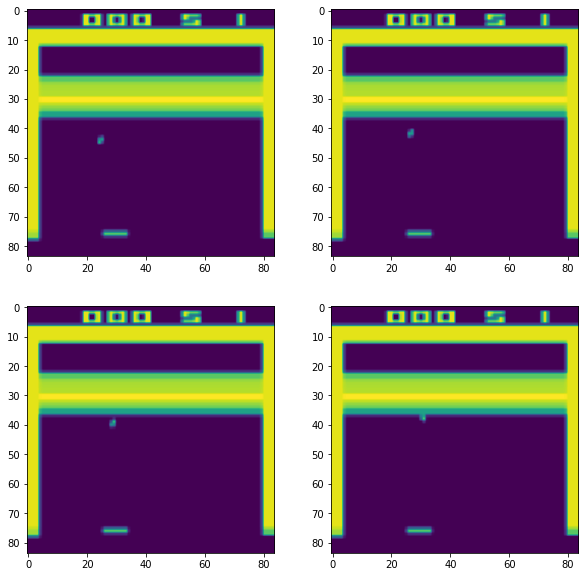

In [13]:
plt.figure(figsize=(10, 10))
for k in range(4):
    plt.subplot(2, 2, k+1)
    plt.imshow(obs[0, :, :, k])

In [42]:
class RewardModel(nn.Module):
    """A reward model using an A2C feature extractor"""
    def __init__(self, env, device):
        super(RewardModel, self).__init__()
        self.ac_model = ALGOS['a2c']('CnnPolicy', env).policy
        self.reward_net = nn.Linear(512, 1).to(device)
        self.device = device
    
    def forward(self, obs):
        obs_transposed = VecTransposeImage.transpose_image(obs)
        latent, _, _= self.ac_model._get_latent(th.tensor(obs_transposed).to(self.device))
        return self.reward_net(latent)
    
    def forward_tensor(self, obs):
        """obs is a tensor which has already been transposed correctly."""
        latent, _, _= self.ac_model._get_latent(obs.to(self.device))
        return self.reward_net(latent)
    
    def freeze_extractor(self):
        for p in self.ac_model.policy.features_extractor.parameters():
            p.requires_grad = False

In [43]:
def create_circular_mask(h, w, center, radius=5):
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[1])**2 + (Y-center[0])**2)
    mask = dist_from_center <= radius
    return np.array(mask, dtype=np.float32)

def max_k(k, iterator, key=lambda x: x):
    items = [None for _ in range(k)]
    values = [-float('inf') for _ in range(k)]
    for item in iterator:
        val = key(item)
        for i in range(k):
            if val > values[i]:
                items.insert(i, item)
                items.pop()
                values.insert(i, val)
                values.pop()
                break
    return items

def max_k_and_values(k, iterator, key=lambda x: x):
    items = [None for _ in range(k)]
    values = [-float('inf') for _ in range(k)]
    for item in iterator:
        val = key(item)
        for i in range(k):
            if val > values[i]:
                items.insert(i, item)
                items.pop()
                values.insert(i, val)
                values.pop()
                break
    return list(zip(items, values))

loss_fn = th.nn.MSELoss()
def policy_saliency(model, obs, loc, radius=5, device='cuda'):
    obs_transposed = VecTransposeImage.transpose_image(np.copy(obs))
    latent, _, _ = model.policy._get_latent(th.from_numpy(obs_transposed).to(device))
    baseline = model.policy.action_net(latent)
    M = create_circular_mask(84, 84, center=loc, radius=radius)
    for k in range(4):
        img = obs_transposed[0, k, :, :]
        A = scipy.ndimage.gaussian_filter(img, 3)
        obs_transposed[0, k, :, :] = img*(1 - M) + A*M
    latent, _, _ = model.policy._get_latent(th.from_numpy(obs_transposed).to(device))
    modified = model.policy.action_net(latent)
    return loss_fn(baseline, modified).item()

def value_saliency(model, obs, loc, radius=5, device='cuda'):
    obs_transposed = VecTransposeImage.transpose_image(np.copy(obs))
    latent, _, _ = model.policy._get_latent(th.from_numpy(obs_transposed).to(device))
    baseline = model.policy.value_net(latent)
    M = create_circular_mask(84, 84, center=loc, radius=radius)
    for k in range(4):
        img = obs_transposed[0, k, :, :]
        A = scipy.ndimage.gaussian_filter(img, 3)
        obs_transposed[0, k, :, :] = img*(1 - M) + A*M
    latent, _, _ = model.policy._get_latent(th.from_numpy(obs_transposed).to(device))
    modified = model.policy.value_net(latent)
    return loss_fn(baseline, modified).item()

def reward_model_saliency(model: RewardModel, obs, loc, radius=5, device='cuda'):
    obs_copy = np.copy(obs)
    baseline = model(obs_copy)
    M = create_circular_mask(84, 84, center=loc, radius=radius)
    for k in range(4):
        img = obs_copy[0, :, :, k]
        A = scipy.ndimage.gaussian_filter(img, 3)
        obs_copy[0, :, :, k] = img*(1 - M) + A*M
    modified = model(obs_copy)
    return loss_fn(baseline, modified).item()

def invert_preprocessing(loc):
    x, y = loc
    return (int(210/84*x), int(160/84*y))

In [44]:
rm = RewardModel(env, device)
rm.load_state_dict(th.load("../reward-models/breakout_rm_v1.pt"))

<All keys matched successfully>

In [45]:
rm(obs)

tensor([[1.0029]], device='cuda:0', grad_fn=<AddmmBackward>)

In [46]:
th.from_numpy(obs).to(th.float32).dtype

torch.float32

In [47]:
obs_transposed = VecTransposeImage.transpose_image(obs)
obs_ten = th.from_numpy(obs_transposed).to(th.float32)
obs_ten.requires_grad = True
rm.forward_tensor(obs_ten).backward()
grad = obs_ten.grad.detach().numpy()
grad = reverse_transpose(grad)

In [57]:
def reverse_transpose(obs):
    return VecTransposeImage.transpose_image(VecTransposeImage.transpose_image(obs))

In [68]:
grad_viewable = reverse_transpose(obs_ten.grad)

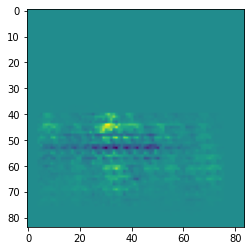

In [72]:
plt.imshow(grad_viewable[0, :, :, 0])

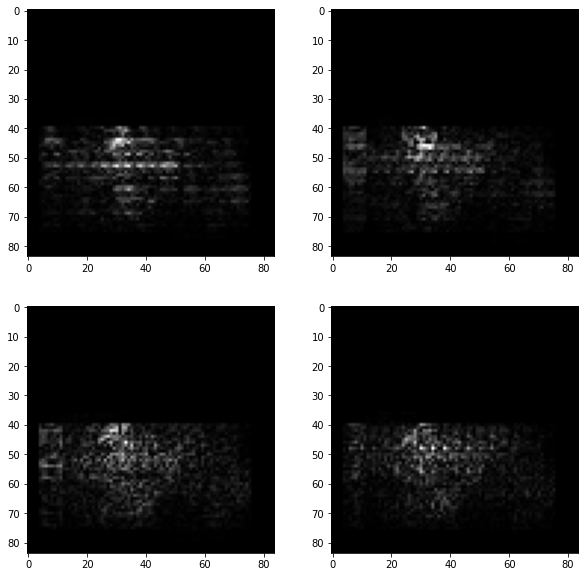

In [79]:
plt.figure(figsize=(10, 10))
for k in range(4):
    plt.subplot(2, 2, k+1)
    plt.imshow(th.abs(grad_viewable[0, :, :, k]), cmap='gray')

In [87]:
spot = skimage.transform.resize(np.abs(grad_viewable.detach().numpy()[0, :, :, 0]), (210, 160))

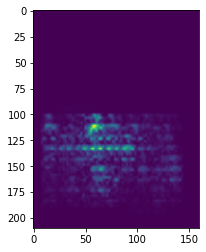

In [88]:
plt.imshow(spot)

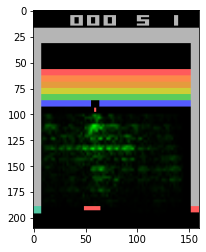

In [100]:
obs_transposed = VecTransposeImage.transpose_image(obs)
obs_ten = th.from_numpy(obs_transposed).to(th.float32)
obs_ten.requires_grad = True
rm.forward_tensor(obs_ten).backward()
grad = obs_ten.grad.detach().numpy()
grad = np.abs(reverse_transpose(grad)[0, :, :, 0])
grad = grad / grad.max()

screenshot = env.get_images()[0]
screenshot = screenshot / screenshot.max()

grad_image = spot = skimage.transform.resize(grad, (210, 160))
screenshot[:, :, 1] = screenshot[:, :, 1] + grad_image
screenshot = screenshot / screenshot.max()
plt.imshow(screenshot)


In [102]:
matplotlib.use("Agg")
import matplotlib.animation as manimation

import warnings
warnings.filterwarnings("ignore")

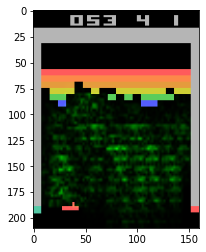

In [103]:
radius = 5
stride = 4

TIMESTEPS = 1000

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Breakout Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)

fig, ax = plt.subplots(1, 1)

obs = env.reset()
imshow = ax.imshow(env.get_images()[0])
with writer.saving(fig, "../videos/breakout_reward_model_saliency_gradients.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        obs_transposed = VecTransposeImage.transpose_image(obs)
        obs_ten = th.from_numpy(obs_transposed).to(th.float32)
        obs_ten.requires_grad = True
        rm.forward_tensor(obs_ten).backward()
        grad = obs_ten.grad.detach().numpy()
        grad = np.abs(reverse_transpose(grad)[0, :, :, 0])
        grad = grad / grad.max()
        
        screenshot = env.get_images()[0]
        screenshot = screenshot / screenshot.max()
        
        grad_image = spot = skimage.transform.resize(grad, (210, 160))
        screenshot[:, :, 1] = screenshot[:, :, 1] + grad_image
        screenshot = screenshot / screenshot.max()
        imshow.set_data(screenshot)
        plt.imshow(screenshot)
        writer.grab_frame()

# Okay so not that useful. Let's try seaquest:

In [106]:
env_id = "SeaquestNoFrameskip-v4"
folder = "../agents"
algo = "a2c"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

In [107]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1

set_random_seed(seed)

if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

env = create_test_env(env_id, n_envs=n_envs,
                      stats_path=stats_path, seed=seed, log_dir=log_dir,
                      should_render=not no_render,
                      hyperparams=hyperparams,
                      env_kwargs=env_kwargs)

model = ALGOS[algo].load(model_path, env=env)

obs = env.reset()

Stacking 4 frames


In [108]:
rm = RewardModel(env, device)
rm.load_state_dict(th.load("../reward-models/seaquest_rm_v1.pt"))

<All keys matched successfully>

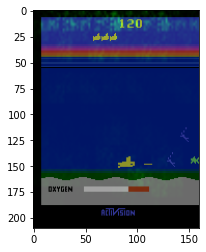

In [111]:
radius = 5
stride = 4

TIMESTEPS = 200

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Breakout Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)

fig, ax = plt.subplots(1, 1)

obs = env.reset()
imshow = ax.imshow(env.get_images()[0])
with writer.saving(fig, "../videos/seaquest_reward_model_saliency_gradients_finalframe.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        obs_transposed = VecTransposeImage.transpose_image(obs)
        obs_ten = th.from_numpy(obs_transposed).to(th.float32)
        obs_ten.requires_grad = True
        rm.forward_tensor(obs_ten).backward()
        grad = obs_ten.grad.detach().numpy()
        grad = np.abs(reverse_transpose(grad)[0, :, :, 3])
        grad = grad / grad.max()
        
        screenshot = env.get_images()[0]
        screenshot = screenshot / screenshot.max()
        
        grad_image = spot = skimage.transform.resize(grad, (210, 160))
        screenshot[:, :, 1] = screenshot[:, :, 1] + grad_image
        screenshot = screenshot / screenshot.max()
        imshow.set_data(screenshot)
        plt.imshow(screenshot)
        writer.grab_frame()

# Let's try integrated gradients now!

In [138]:
env_id = "BreakoutNoFrameskip-v4"
folder = "../agents"
algo = "a2c"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 3
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

In [139]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1

set_random_seed(seed)

if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

env = create_test_env(env_id, n_envs=n_envs,
                      stats_path=stats_path, seed=seed, log_dir=log_dir,
                      should_render=not no_render,
                      hyperparams=hyperparams,
                      env_kwargs=env_kwargs)

model = ALGOS[algo].load(model_path, env=env)

obs = env.reset()

Stacking 4 frames


In [140]:
rm = RewardModel(env, device)
rm.load_state_dict(th.load("../reward-models/breakout_rm_v1.pt"))

<All keys matched successfully>

In [143]:
obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if reward[0]:
        break

In [144]:
def get_grad(obs, k=0):
    obs_transposed = VecTransposeImage.transpose_image(obs)
    obs_ten = th.from_numpy(obs_transposed).to(th.float32)
    obs_ten.requires_grad = True
    rm.forward_tensor(obs_ten).backward()
    grad = obs_ten.grad.detach().numpy()
    grad = reverse_transpose(grad)
    return grad

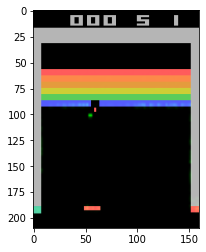

In [153]:
dalpha = 0.05
baseline = np.zeros((1, 84, 84, 4))
obs_scaled = [obs*alpha for alpha in np.arange(0, 1, dalpha)]
s = sum([get_grad(obs) for obs in obs_scaled]) * dalpha
IG = (obs - baseline) * s
IG = np.abs(IG[0, :, :, 2])
IG = IG / IG.max()

screenshot = env.get_images()[0]
screenshot = screenshot / screenshot.max()

grad_image = skimage.transform.resize(IG, (210, 160))
screenshot[:, :, 1] = screenshot[:, :, 1] + grad_image
screenshot = screenshot / screenshot.max()
plt.imshow(screenshot)

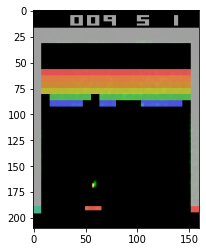

In [154]:
TIMESTEPS = 300

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Breakout Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)

fig, ax = plt.subplots(1, 1)

obs = env.reset()
imshow = ax.imshow(env.get_images()[0])
with writer.saving(fig, "../videos/breakout_reward_model_saliency_integrated_gradients.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        dalpha = 0.05
        baseline = np.zeros((1, 84, 84, 4))
        obs_scaled = [obs*alpha for alpha in np.arange(0, 1, dalpha)]
        s = sum([get_grad(obs) for obs in obs_scaled]) * dalpha
        IG = (obs - baseline) * s
        IG = np.abs(IG[0, :, :, 3])
        IG = IG / IG.max()

        screenshot = env.get_images()[0]
        screenshot = screenshot / screenshot.max()

        grad_image = skimage.transform.resize(IG, (210, 160))
        screenshot[:, :, 1] = screenshot[:, :, 1] + grad_image
        screenshot = screenshot / screenshot.max()
        imshow.set_data(screenshot)
        writer.grab_frame()

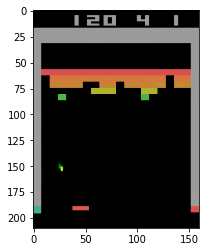

In [155]:
TIMESTEPS = 500

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Breakout Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)

fig, ax = plt.subplots(1, 1)

obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)

imshow = ax.imshow(env.get_images()[0])
with writer.saving(fig, "../videos/breakout_reward_model_saliency_integrated_gradients_later.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        dalpha = 0.05
        baseline = np.zeros((1, 84, 84, 4))
        obs_scaled = [obs*alpha for alpha in np.arange(0, 1, dalpha)]
        s = sum([get_grad(obs) for obs in obs_scaled]) * dalpha
        IG = (obs - baseline) * s
        IG = np.abs(IG[0, :, :, 3])
        IG = IG / IG.max()

        screenshot = env.get_images()[0]
        screenshot = screenshot / screenshot.max()

        grad_image = skimage.transform.resize(IG, (210, 160))
        screenshot[:, :, 1] = screenshot[:, :, 1] + grad_image
        screenshot = screenshot / screenshot.max()
        imshow.set_data(screenshot)
        writer.grab_frame()

In [156]:
env_id = "SeaquestNoFrameskip-v4"
folder = "../agents"
algo = "a2c"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

In [157]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1

set_random_seed(seed)

if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

env = create_test_env(env_id, n_envs=n_envs,
                      stats_path=stats_path, seed=seed, log_dir=log_dir,
                      should_render=not no_render,
                      hyperparams=hyperparams,
                      env_kwargs=env_kwargs)

model = ALGOS[algo].load(model_path, env=env)

obs = env.reset()

Stacking 4 frames


In [158]:
rm = RewardModel(env, device)
rm.load_state_dict(th.load("../reward-models/seaquest_rm_v1.pt"))

<All keys matched successfully>

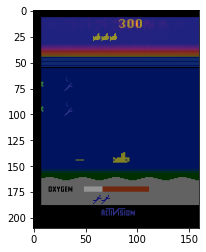

In [159]:
TIMESTEPS = 400

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Breakout Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)

fig, ax = plt.subplots(1, 1)

obs = env.reset()
imshow = ax.imshow(env.get_images()[0])
with writer.saving(fig, "../videos/seaquest_reward_model_saliency_integrated_gradients.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        dalpha = 0.05
        baseline = np.zeros((1, 84, 84, 4))
        obs_scaled = [obs*alpha for alpha in np.arange(0, 1, dalpha)]
        s = sum([get_grad(obs) for obs in obs_scaled]) * dalpha
        IG = (obs - baseline) * s
        IG = np.abs(IG[0, :, :, 3])
        IG = IG / IG.max()

        screenshot = env.get_images()[0]
        screenshot = screenshot / screenshot.max()

        grad_image = skimage.transform.resize(IG, (210, 160))
        screenshot[:, :, 0] = screenshot[:, :, 0] + grad_image
        screenshot = screenshot / screenshot.max()
        imshow.set_data(screenshot)
        writer.grab_frame()

# What about enduro?

In [160]:
env_id = "EnduroNoFrameskip-v4"
folder = "../agents"
algo = "ppo"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

In [162]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1

set_random_seed(seed)

if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

env = create_test_env(env_id, n_envs=n_envs,
                      stats_path=stats_path, seed=seed, log_dir=log_dir,
                      should_render=not no_render,
                      hyperparams=hyperparams,
                      env_kwargs=env_kwargs)

model = ALGOS[algo].load(model_path, env=env)

obs = env.reset()

Stacking 4 frames


In [163]:
rm = RewardModel(env, device)
rm.load_state_dict(th.load("../reward-models/enduro_rm_v1.pt"))

<All keys matched successfully>

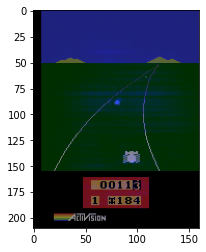

In [166]:
TIMESTEPS = 300

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Breakout Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)

fig, ax = plt.subplots(1, 1)

obs = env.reset()
imshow = ax.imshow(env.get_images()[0])
with writer.saving(fig, "../videos/enduro_reward_model_saliency_integrated_gradients.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        dalpha = 0.05
        baseline = np.zeros((1, 84, 84, 4))
        obs_scaled = [obs*alpha for alpha in np.arange(0, 1, dalpha)]
        s = sum([get_grad(obs) for obs in obs_scaled]) * dalpha
        IG = (obs - baseline) * s
        IG = np.abs(IG[0, :, :, 3])
        IG = IG / IG.max()

        screenshot = env.get_images()[0]
        screenshot = screenshot / screenshot.max()

        grad_image = skimage.transform.resize(IG, (210, 160))
        screenshot[:, :, 2] = screenshot[:, :, 2] + grad_image
        screenshot = screenshot / screenshot.max()
        imshow.set_data(screenshot)
        writer.grab_frame()